# Data Analysis

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.max_columns", None)


account = pd.read_csv('data/account.csv', dtype={'date':object})
card_dev = pd.read_csv('data/card_dev.csv', dtype={'issued':object})
client = pd.read_csv('data/client.csv', dtype={'birth_number':object})
disposition = pd.read_csv('data/disp.csv')
district = pd.read_csv('data/district.csv')
loan_dev = pd.read_csv('data/loan_dev.csv', dtype={'date':object})
trans_dev = pd.read_csv('data/trans_dev.csv', 
                        dtype={'account_id':int, 'date':object, 'type':object, 'operation':object, 'amount':float, 'balance':float, 'k_symbol':object, 'bank':object, 'account':float})

data = pd.read_csv('data_processed/data.csv')

## General Attribute Analysis

The data is organized in data tables so each table has an ammount of attributes that can be analised to better understand their significance.

In [ ]:
print(f'''
account     shape: {account.shape}
client      shape: {client.shape}
disposition shape: {disposition.shape}
district    shape: {district.shape}
card        shape: {card_dev.shape}
loan        shape: {loan_dev.shape}
trans       shape: {trans_dev.shape}

data        shape: {data.shape}
''')

In [ ]:
def get_correlation(df):   
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    plt.subplots(figsize=(30,24))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot = True)

    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))
    
    plt.savefig('correlation.svg')
    plt.show()

In [ ]:
def plot_PCA(df):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [-1, 1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = df['status'] == target
        ax.scatter(df.loc[indicesToKeep, 'principal component 1']
                , df.loc[indicesToKeep, 'principal component 2']
                , c = color)
    ax.legend(targets)
    ax.grid()

In [ ]:
def get_PCA(X, y):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    print(pca.explained_variance_ratio_)
    display(pca.components_)

    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, y], axis = 1)
    return finalDf

In [ ]:
def convert_date(df):
    aux = df.apply(lambda x: '19'+x[:2]+'-'+x[2:4]+'-'+x[4:])
    return pd.to_datetime(aux).dt.date


## Account Analysis

In [ ]:
display(account.head())
print(account.info())
display(account.describe())


In [ ]:
account_frequency = account["frequency"].value_counts()
display(account_frequency)

plt.title("Account Frequency")
plt.bar(list(account_frequency.keys()), list(account_frequency))

In [ ]:
account['date_ts'] = convert_date(account['date'])
print(account['date_ts'].min())
print(account['date_ts'].max())

### Features conclusions
- Most of the `account frequency` values are "monthly issuance". Are the others values relevant to determine the `status`?
- Accounts `date` are between 1993 and 1997

## Card Analysis

In [ ]:
display(card_dev.head())
display(card_dev.info())
display(card_dev.describe())


In [ ]:
card_type = card_dev["type"].value_counts()
display(card_type)

plt.figure()
plt.title("Card Type")
plt.bar(list(card_type.keys()), list(card_type))

In [ ]:
card_dev['issued_ts'] = convert_date(card_dev['issued'])
print(card_dev['issued_ts'].min())
print(card_dev['issued_ts'].max())

### Features conclusions
- Card `issued` dates are between 1993 and 1996

## Client Analysis

In [ ]:
client = pd.read_csv('data_processed/client.csv', dtype={'birth_number':object})

In [ ]:
display(client.head())
display(client.info())
display(client.describe())


In [ ]:
client['birth_number_ts'] = convert_date(client['birth_number'])
print(client['birth_number_ts'].min())
print(client['birth_number_ts'].max())

In [ ]:
# merge client gender value counts and percentage
m, f = client['gender'].value_counts().values
print('Total clients: ', m+f)
print('Males:   {} %'.format(round(m/(m+f), 2)))
print('Females: {} %'.format(round(f/(m+f), 2)))


### Features conclusions
- The oldest client is around 86 years old and youngest is 10 years old
- Clients `gender` are balanced

## Disposition Analysis

In [ ]:
display(disposition.head())
display(disposition.info())
display(disposition.describe())


In [ ]:
disp_type = disposition["type"].value_counts()
display(disp_type)

plt.figure()
plt.title("Disposition Type")
plt.bar(list(disp_type.keys()), list(disp_type))

In [ ]:
n_clients = len(disposition['client_id'].unique())
n_dispositions = len(disposition['disp_id'].unique())
print('Is there any client with more than one disposition? {}'.format('Yes' if n_clients != n_dispositions else 'No'))

### Features conclusions
- Every `client_id` corresponds to a single `disp_id` and vice-versa

## District Analysis

In [ ]:
display(district.head())
display(district.info())
display(district.describe())


In [ ]:
district_name = district["name"].value_counts()
display(district_name)
plt.figure(figsize=[6.4, 20])
plt.title("District Name")
plt.barh(list(district_name.keys()), list(district_name))

district_region = district["region"].value_counts()
display(district_region)
plt.figure()
plt.title("District Region")
plt.barh(list(district_region.keys()), list(district_region))

### Features conclusions

- District `name` is unique for each district


## Transaction Analysis

In [ ]:
display(trans_dev.head())
display(trans_dev.info())

In [ ]:
trans_type = trans_dev["type"].value_counts()
trans_operation = trans_dev["operation"].value_counts()
trans_k_symbol = trans_dev["k_symbol"].value_counts()
trans_bank = trans_dev["bank"].value_counts()

fig, ((ax2, ax1), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.title.set_text("Transaction Type")
ax1.bar(list(trans_type.keys()), list(trans_type))
ax2.title.set_text("Transaction Operation")
ax2.barh(list(trans_operation.keys()), list(trans_operation))
ax3.title.set_text("Transaction K_symbol")
ax3.barh(list(trans_k_symbol.keys()), list(trans_k_symbol))
ax4.title.set_text("Transaction Bank")
ax4.bar(list(trans_bank.keys()), list(trans_bank))
plt.show()

In [ ]:
trans_dev_no_mv = pd.read_csv('data_processed/trans_dev_no_mv.csv')

In [ ]:
display(trans_dev_no_mv.head())
display(trans_dev_no_mv.info())
display(trans_dev_no_mv.describe())

In [ ]:
trans_type = trans_dev_no_mv["type"].value_counts()
trans_operation = trans_dev_no_mv["operation"].value_counts()
trans_k_symbol = trans_dev_no_mv["k_symbol"].value_counts()

fig, ((ax2, ax1), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.title.set_text("Transaction Type")
ax1.bar(list(trans_type.keys()), list(trans_type))
ax2.title.set_text("Transaction Operation")
ax2.barh(list(trans_operation.keys()), list(trans_operation))
ax3.title.set_text("Transaction K_symbol")
ax3.barh(list(trans_k_symbol.keys()), list(trans_k_symbol))
ax4.title.set_text("Transaction Bank")
plt.show()

In [ ]:
# Describe mean balance for each account

balance_mean_by_account = trans_dev_no_mv.groupby('account_id')['balance'].mean()
display(balance_mean_by_account.describe())


In [ ]:
# Describe mean transaction amount for each transaction type

amount_mean_by_transaction_type = trans_dev_no_mv.groupby('type')['amount'].mean()
display(amount_mean_by_transaction_type)

amount_mean_by_transaction_operation = trans_dev_no_mv.groupby('operation')['amount'].mean()
display(amount_mean_by_transaction_operation)

### Features conclusions
- Transaction `type` "withdrawal in cash" is most likely an input error so it should be "withdrawal"
- Transaction `operation` "credit card withdrawal" looks like it is logically irrelevant
- Transaction `operation` has null values but it has potential to be an important feature since it describes the transaction
- Transaction `k_symbol` has empty values besides NaN, they can be considered as NaN

## Loan Analysis

In [ ]:
display(loan_dev.head())
display(loan_dev.info())
display(loan_dev.describe())


In [ ]:
loan_dev['date_ts'] = convert_date(loan_dev['date'])
print(loan_dev['date_ts'].min())
print(loan_dev['date_ts'].max())

The plot below shows that a big majority of the loans were given, what represents a strng imbalance in the target column. This situation usally leads models to have the tendency to opt for the class more populated, in this case answering 'yes' to the loan.

In [ ]:
loan_status = loan_dev['status'].value_counts()
plt.title("Was the loan given?")
plt.bar(['yes', 'no'], list(loan_status))

In the box plot and histogram below we can see that the duration of the loans has a uniform distribution.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 4.8)
fig.suptitle("Duration of the loans")

ax1.boxplot(loan_dev["duration"])
ax2.hist(loan_dev["duration"].values, [6, 18, 30, 42, 54, 66])
plt.show()

In the box plot and histogram below we can see that the amount of money requested for loans looks like a poisson distribution. The density of the data until the median is much greater than after it. Also, in the box plot, it's poossible to verify the existence of some outliers.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 4.8)
fig.suptitle("Amount of the loans")

ax1.boxplot(loan_dev["amount"])
ax2.hist(loan_dev["amount"].values, 30)
plt.show()

By observation of the below scatter plots and histograms, we can conclude that the duration of the loan is not connected with the status of the loan since it have an uniform distribution. On the other hand, either the amount and the payments looks like they can be related since the percentage of negative status in higher payments and amounts is greater than it is in the lower ones.

In [ ]:
from matplotlib.patches import Rectangle


amount = loan_dev['amount']
duration = loan_dev['duration']
payments = loan_dev['payments']

colors = ['g' if s == 1 else 'r' for s in loan_dev['status']]

fig, (ax1, ax2,  ax3) = plt.subplots(3, figsize=[15, 15])
ax1.scatter(amount, duration, color=colors)
ax1.set_xlabel('Loan amount')
ax1.set_ylabel('Duration')
ax2.scatter(amount, payments, color=colors)
ax2.set_xlabel('Loan amount')
ax2.set_ylabel('Payments')
ax3.scatter(payments, duration, color=colors)
ax3.set_xlabel('Payments')
ax3.set_ylabel('Duration')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 4.8])
handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ['C0', 'C1']]

ax1.hist(payments, list(range(0, 10001, 500)), color='C0')
ax1.hist(loan_dev.query('status == -1')['payments'], list(range(0, 10001, 500)), color='C1')
ax1.set_xlabel('Payment')
ax1_labels = ["All payments", "Payments without loan"]
ax1.legend(handles, ax1_labels)

ax2.hist(amount, list(range(0, 600001, 40000)), color='C0')
ax2.hist(loan_dev.query('status == -1')['amount'], list(range(0, 600001, 40000)), color='C1')
ax2.set_xlabel('Amount')
ax2_labels = ["All amounts", "Amounts without loan"]
ax2.legend(handles, ax2_labels)

ax3.hist(duration, list(range(6, 70, 12)), color='C0')
ax3.hist(loan_dev.query('status == -1')['duration'], list(range(6, 70, 12)), color='C1')
ax3.set_xlabel('Duration')
ax3.set_xticks(list(range(12, 61, 12)))
ax3_labels = ["All durations", "Durations without loan"]
ax3.legend(handles, ax3_labels)
plt.show()

In [ ]:
from datetime import date

date_ts1 = loan_dev.query('status == 1')['date_ts'].apply(lambda x: x.toordinal())
payments1 = loan_dev.query('status == 1')['payments']

date_ts2 = loan_dev.query('status == -1')['date_ts'].apply(lambda x: x.toordinal())
payments2 = loan_dev.query('status == -1')['payments']

z1 = np.polyfit(date_ts1, payments1, 1)
p1 = np.poly1d(z1)
z2 = np.polyfit(date_ts2, payments2, 1)
p2 = np.poly1d(z2)

plt.figure(figsize=[10, 4.8])
plt.scatter(date_ts1, payments1, color=['g' for _ in range(len(date_ts1))])
plt.plot(date_ts1, p1(date_ts1), "g--")
plt.scatter(date_ts2, payments2, color=['r' for _ in range(len(date_ts2))])
plt.plot(date_ts2, p2(date_ts2), "r--")
aux = plt.xticks()
new_labels = [date.fromordinal(int(item)) for item in aux[0]]
plt.xticks(aux[0], new_labels)
plt.xlabel('Date')
plt.ylabel('Payments')
plt.show()

### Features conclusions
- Loan `duration` doesn't seems to be relevant for the `status` since the distribution porportion is similar for both status
- Loan higher `payments` leads to a greater probability of a `status` of -1
- Loan `payments` correspondent to `status` -1 decrease along the time

## Integrated Data Analysis

In [148]:
# Get data selected
data_selected = pd.read_csv('data_processed/data_selected.csv')
target_selected = data_selected['status']
data_selected_no_status = data_selected.drop(['status'], axis=1)

In [ ]:
# Relation between status and monthly_diff
status_median_monthly_diff = data.groupby('status')['monthly_diff'].median()
display(status_median_monthly_diff)

aux = {'Status 1': data[data['status'] == 1]['monthly_diff'].values, 'Status -1': data[data['status'] == -1]['monthly_diff'].values}
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle('Monthly diff for status = 1 and status = -1')
ax.boxplot(aux.values())
ax.set_xticklabels(aux.keys())
plt.show()


The plot below indicates that the gender of the client that requested the loan have no significant impact on the choice of loan or not.

In [ ]:
labels = ['loan', 'no loan']
aux = data.groupby('gender')['status'].value_counts()
female = aux[:2]
male = aux[2:]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male, width, label='Men')
rects2 = ax.bar(x + width/2, female, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Loans given or not by gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)
plt.show()

### Correlation Map

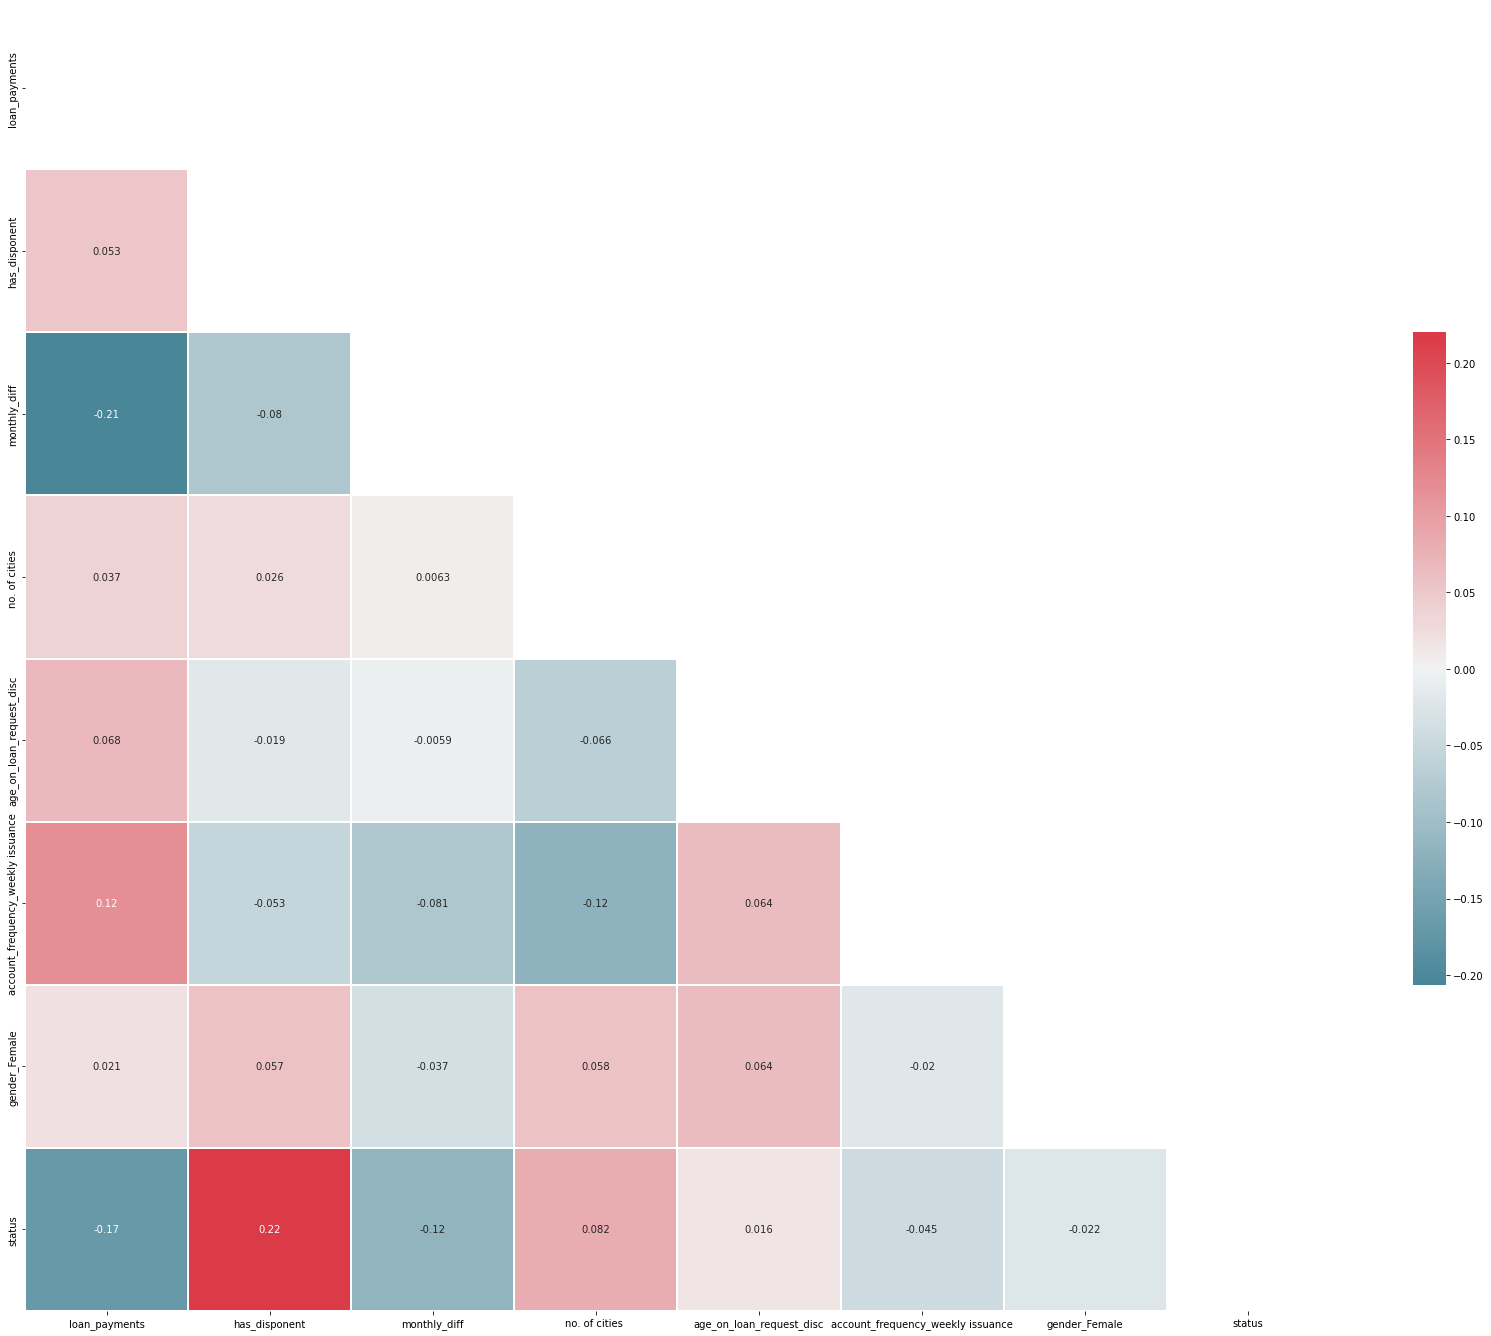

In [149]:
SELECTED = True
if SELECTED:
    get_correlation(data_selected)
else:
    no_ids = [c for c in data.columns if c[-3:] != '_id' and c != 'code']
    no_ids.remove('status')
    no_ids.append('status')

    get_correlation(data[no_ids])

### Principal Component Analysis (PCA)

[0.16784192 0.16357663]


array([[ 0.44996905, -0.35833095, -0.12150441, -0.31825103,  0.22910034,
         0.46326436, -0.02283964, -0.53428201],
       [ 0.43516791,  0.4748043 , -0.60894471,  0.10772068,  0.15120183,
         0.17241336,  0.20659836,  0.32787363]])

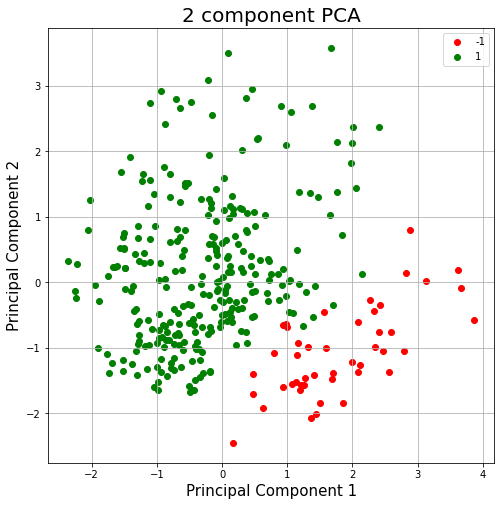

In [150]:
SELECTED = True
if SELECTED:
    from sklearn.preprocessing import StandardScaler

    # Standardizing the features
    data_selected = StandardScaler().fit_transform(data_selected)

    finalDf = get_PCA(data_selected, data[['status']])
    plot_PCA(finalDf)
